In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import pandas as pd
import matplotlib.image as mpimg
import glob
import re

from scipy import interpolate
import scipy.optimize
import numba
import emcee


from tqdm.notebook import tqdm

import sys
sys.path.append('../')
from functions import *

In [6]:
show_details = True

In [7]:
@numba.njit
def deflection_exact(param, x_dat, y_dat, L, xj, n_div=100):
    """
    Calculates the deflection profile of the k-fiber
    using the exact nonlinear expression of curvature 
    in the Euler-Bernoulli equation.
    
    Parameters
    ----------
    param : array_like
        Mechanical parameters at the pole, along with the starting k-fiber
        angle relative to the pole-kinetochore axis.
        
    x_dat : float or numpy array
        Measured x-positions of a k-fiber profile.
    
    y_dat : float or numpy array
        Measured y-positions of a k-fiber profile.
        
    L : float
        End-to-end distance of the curved beam.
        
    n_div : int
        Number of small divisions in the generated k-fiber profile in the
        `length_conserved=True` case. When `length_conserved=False`, up to
        4 times more divisions are allowed.
    
    
    Returns
    -------
    x_ls : numpy array
        x-positions of the predicted profile.
        
    y_ls : numpy array
        y-positions of the predicted profile.
    """
    
    Rx, M0, Ry, theta0, Jx, Jy = param
    
    s_dat_ls, L_contour = contour_fn(x_dat, y_dat)
    ds = L_contour/n_div
    n_steps = int(1.15*n_div)
    
    
    theta_ls = np.zeros(n_steps)
    theta_ls[0] = theta0
    
    x_ls = np.zeros(n_steps)
    y_ls = np.zeros(n_steps)
    M_ls = np.zeros(n_steps)
    
    M_ls[0] = M0
    
    found_j = False
    
    for i in range(n_steps-1):
        
        xF_sign = np.sign(xj) * np.sign(xj - x_ls[i])
        if xF_sign < 0 and found_j == False:
            found_j = True
            iF = i-1
            yj = interpolate_two_pt(xj, x_ls[iF], x_ls[iF+1], y_ls[iF], y_ls[iF+1])
            
        M = M0 + Rx*y_ls[i] - Ry*x_ls[i]
        if found_j:
            M += Jx*(y_ls[i]-yj) - Jy*(x_ls[i]-xj)
        
        
        theta_mid = theta_ls[i] - ds/2*M
        y_mid = y_ls[i] + ds/2*np.sin(theta_mid)
        x_mid = x_ls[i] + ds/2*np.cos(theta_mid)

        M_mid = M0 + Rx*y_mid - Ry*x_mid
        if found_j:
            M_mid += Jx*(y_mid-yj) - Jy*(x_mid-xj)
        
        theta_ls[i+1] = theta_ls[i] - ds*M_mid
        x_ls[i+1] = x_ls[i] + ds*np.cos(theta_mid)
        y_ls[i+1] = y_ls[i] + ds*np.sin(theta_mid)
        
        M_ls[i+1] = M_mid
        
    return x_ls, y_ls, M_ls, yj

@numba.njit
def res_fn_exact(param, x_dat, y_dat, L, xj, M0_zero=False):
    
    Rx, M0, Ry, theta0, Jx, Jy = param
    
    if M0_zero:
        M0 = 0
        
    param = Rx, M0, Ry, theta0, Jx, Jy
    
    x_mod, y_mod, _, _ = deflection_exact(param, x_dat, y_dat, L, xj)
    
    res = distances_pair_min_new(x_dat, y_dat, x_mod, y_mod)
            
    return res

@numba.njit
def logpost_exact(param, x_dat, y_dat, L, xj, M0_zero=False, end_to_end=np.inf):    
    
    # Unpack the parameters
    Rx, M0, Ry, theta0, Jx, Jy = param
    
    # Make sure parameters do not wander far during MCMC
    if np.max(np.abs(param)) > 1e2:
        return -np.inf
    
    if M0_zero:
        M0 = 0
        
    if M0 < 0:
        return -np.inf
    
    # Kinetochore force should not point inward
    # (note: this is for a flipped profile)
    if Rx > 0:
        return -np.inf
    
    # Tension force at the junction cannot excede the force at the pole
    if abs(Rx) > abs(Jx):
        return -np.inf
    
    # Junction force needs to point inward
    if Jx < 0:
        return -np.inf
        
    # Upper-bound on junction force to be within 1 nN (EI = 400 pN.um^2)
    if np.abs(Jx) > 2.5:
        return -np.inf
        
    # Calculate the profile
    x_mod, y_mod, M_mod, _ = deflection_exact(param, x_dat, y_dat, L, xj)
    
    # No negative curvature in unmanipulated profiles
    if np.sum(M_mod < 0) > 0:
        return -np.inf
    
    
    res = res_fn_exact(param, x_dat, y_dat, L, xj, M0_zero=M0_zero)
    
    penalty_end_match = 1+(res[-1]/end_to_end)**2
    
    return -10*( np.log(np.sum(res**2)) + np.log(penalty_end_match) )

In [8]:
cols = ['Rx', 'M0', 'Ry', 'theta0', 'Jx', 'Jy'] # Parameter names for MCMC inference
n_dim = len(cols) # Number of parameters in the model

n_walkers = 15     # number of MCMC walkers
n_steps = 10000    # number of MCMC steps during each filtering round
sigma_start = 0.02 # standard deviation of the random multiplying factor centered
                   # around 1, used to randomize the initial positions of the walkers
end_to_end = 0.01  # End-to-end distance for end-matching

path = "../../dat/WT unmanipulated k-fiber shapes/"
cells = sorted(glob.glob("%s/*"%path))
cells = [cell for cell in cells if not 'Icon' in cell]
# cells

../../dat/WT unmanipulated k-fiber shapes/20171215_cell005/20171215_cell005_before_bridge_0.csv 0
20171215_cell005 0
pole_left 13.807007798940361
P-K distance (L) =  6.22 um
Initial angle =  25.90 degrees


  0%|                                                 | 0/10000 [00:00<?, ?it/s]/Users/vahegalstyan/anaconda3/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|████████████████████████████████████| 10000/10000 [00:37<00:00, 267.53it/s]


COMPARISON
0.0761919786253702 0.08452890977068739
Exact method error (mcmc): 0.0117


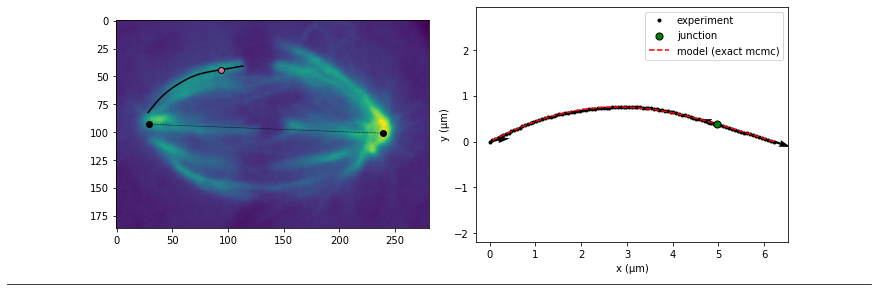

In [18]:
np.random.seed(0)

M0_zero = True
flip = True

df_fin = pd.DataFrame()

for cell in cells:
    spindle = cell.split("/")[-1].split(".")[0]
    image = mpimg.imread("%s/%s_before.tif"%(cell,spindle))
    profiles = sorted(list(set(glob.glob("%s/*.csv"%cell)) - set(glob.glob("%s/*poles.csv"%cell)) - set(glob.glob("%s/*bridge*.csv"%cell))))
    pole_csv = glob.glob("%s/*poles.csv"%cell)[-1]
    bridge_csv_ls = glob.glob("%s/*bridge*.csv"%cell)
    
    if len(bridge_csv_ls) > 0:
        for bridge_csv in bridge_csv_ls: 
            kfiber_number = bridge_csv.split("/")[-1].split(".")[0].split("_")[-1]
            print(bridge_csv,kfiber_number)
            for profile in profiles:
                if profile.split("/")[-1].split(".")[0].split("_")[-1] == bridge_csv.split("/")[-1].split(".")[0].split("_")[-1]:
                    print(spindle, kfiber_number)
                    fig, ax = plt.subplots(1, 2, figsize = (10, 4))

                    # Raw data input
                    df_bridge = pd.read_csv(bridge_csv)
                    df_pole = pd.read_csv(pole_csv)
                    df_profile = pd.read_csv(profile)

                    x_dat = np.array(df_profile["X"].values)
                    y_dat = np.array(df_profile["Y"].values)

                    # Show the spindle image & overlaid k-fiber profile
                    ax[0].imshow(image)
                    ax[0].plot(x_dat, y_dat, color = 'k')

                    x_bridge = np.array(df_bridge["X"].values)[0]
                    y_bridge = np.array(df_bridge["Y"].values)[0]
                    res, indices = distances_pair_min(np.array([x_bridge]), np.array([y_bridge]),x_dat, y_dat)
                    x_bridge, y_bridge = x_dat[int(indices[0])], y_dat[int(indices[0])]
                    
                    ax[0].scatter(x_bridge, y_bridge, color='palevioletred', edgecolor='k', zorder=10)

                    # Pole coordinates & plotting
                    P1x = np.array(df_pole["X"].values)[0]
                    P1y = np.array(df_pole["Y"].values)[0]
                    P2x = np.array(df_pole["X"].values)[1]
                    P2y = np.array(df_pole["Y"].values)[1]
                    ax[0].scatter([P1x, P2x], [P1y, P2y], color='k')
                    ax[0].plot([P1x, P2x], [P1y, P2y], color='k', ls='--', lw=0.5)                    
                    
                    # Angle that the pole-kinetochore line
                    # forms with the pole-pole axis
                    PP_vector = [P2x-P1x, P2y-P1y]
                    K_vector = [x_dat[-1]-x_dat[0], y_dat[-1]-y_dat[0]]
                    unit_PP_vector = PP_vector / np.linalg.norm(PP_vector)
                    unit_K_vector = K_vector / np.linalg.norm(K_vector)
                    dot_product = np.dot(unit_PP_vector, unit_K_vector)
                    PP_K_angle = np.arccos(dot_product)
                    if PP_K_angle > np.pi/2:
                        PP_K_angle = np.pi - PP_K_angle

                    # Identify the spindle side in which the k-fiber lies
                    x_mean = np.mean(x_dat)
                    y_mean = np.mean(y_dat)
                    dist_P1 = np.sqrt((x_mean-P1x)**2 + (y_mean-P1y)**2)
                    dist_P2 = np.sqrt((x_mean-P2x)**2 + (y_mean-P2y)**2)
                    if dist_P2 < dist_P1:
                        pole = "pole_right"
                        x_dat = -x_dat
                        x_bridge = -x_bridge
                    else:
                        pole = "pole_left"

                    # Rotate to have the end-points at y=0
                    angle = np.arctan((y_dat[-1] - y_dat[0]) / (x_dat[-1] - x_dat[0]))
                    x_dat, y_dat = rotate(x_dat, y_dat, angle)
                    x_bridge, y_bridge = rotate(x_bridge, y_bridge, angle)

                    # Translation to start at origin
                    x_bridge -= x_dat[0]
                    y_bridge -= y_dat[0]
                    x_dat -= x_dat[0]
                    y_dat -= y_dat[0]

                    # Flipping to ensure a positive initial slope
                    theta0 = np.arctan2(y_dat[3]-y_dat[0], x_dat[3]-x_dat[0])
                    if theta0 < 0.0:
                        y_bridge = -y_bridge
                        y_dat = -y_dat
                        angle = -angle
                        
                    # Convert from pixel to micron units based on scope camera calibration
                    is_2017 = re.search('2017',cell.split("/")[-1])
                    is_2021 = re.search('2021',cell.split("/")[-1])
                    if is_2017:
                        scope_calibration = 0.0657
                    elif is_2021:
                        scope_calibration = 0.0657
                    else:
                        scope_calibration = 0.105

                    x_dat = x_dat*scope_calibration
                    y_dat = y_dat*scope_calibration
                    xj = x_bridge*scope_calibration
                    
                    # Pole-kinetochore (P-K) distance
                    L = x_dat[-1] - x_dat[0]

                    ## pole-pole distance
                    PP_dist = np.sqrt((P2y-P1y)**2+(P2x-P1x)**2) * scope_calibration

                    # Initial angle in the rotated profile
                    theta_init = np.arctan2(y_dat[3]-y_dat[0], x_dat[3]-x_dat[0])

                    if show_details:
                        print(pole,PP_dist)
                        print("P-K distance (L) =  %.2f um" % L)
                        print("Initial angle =  %.2f degrees" % np.degrees(theta_init))


                    if flip:
                        # Flip the profile
                        x_dat = L - x_dat
                        xj = L - xj
                        x_dat = np.flip(x_dat)
                        y_dat = np.flip(y_dat)
                        


                    # ----------------- Parameter inference: Large angle (MCMC) ----------------- #


                    p_init = np.array([-0.05, 0, -0.01, np.radians(10), 0.05, 0.01])
                    p_init_mat = np.tile(p_init, (n_walkers, 1))

                    args = (x_dat, y_dat, L, xj, M0_zero, end_to_end)
                    sampler = emcee.EnsembleSampler(n_walkers, n_dim, logpost_exact, args=args, threads=3)

                    p_opt_mat = p_init_mat

                    for j in range(n_dim):
                        p_opt_mat[:,j] *= np.random.normal(1.0, sigma_start, n_walkers)
                        p_opt_mat[:,j] += np.random.normal(1e-4, 1e-5, n_walkers)
                    for n in range(n_walkers):
                        if p_opt_mat[n,1] < 0:
                            p_opt_mat[n,1] = np.abs(np.random.normal(0, 1e-5))
                        if p_opt_mat[n,1] - p_opt_mat[n,2]*L < 0:
                            p_opt_mat[n,2] = np.abs(np.random.normal(0, 1e-7))
                        Fc = np.pi**2/L**2
                        if p_opt_mat[n,0] > 1.3*Fc:
                            p_opt_mat[n,0] = 1.2*Fc*np.random.normal(1.0, sigma_start)

                    _ = sampler.run_mcmc(p_opt_mat, n_steps, progress=True)

                    df_mcmc = sampler_to_dataframe(sampler, columns=cols)
                    
                    
                    err_ls = []
                    df_mcmc_arr = np.array(df_mcmc)

                    for i in range(len(df_mcmc)):
                        param = df_mcmc_arr[i][:-2]

                        if case == 'Fx_Fy_Mp':
                            param[1] = 0

                        x_mcmc_sample, y_mcmc_sample, _, _ = deflection_exact(param, x_dat, y_dat, L, xj)

                        y_mcmc_sample = y_mcmc_sample[x_mcmc_sample <= L]
                        x_mcmc_sample = x_mcmc_sample[x_mcmc_sample <= L]

                        res_mcmc_sample = distances_pair_min_new(x_dat, y_dat, x_mcmc_sample, y_mcmc_sample)
                        err_mcmc_sample = np.sqrt(np.mean(res_mcmc_sample**2))
                        err_ls.append(err_mcmc_sample)

                    err_ls = np.array(err_ls)


                    
                    
                    err_extra_options = [0.01, 0.02, 0.03]
                    for err_extra in err_extra_options:
                        ind = np.where(err_ls < err_ls.min() + err_extra)[0]
                        
                        Rx_ls = []
                        Ry_ls = []
                        Mp_ls = []
                    
                        for i in ind:
                            param = df_mcmc_arr[i][:-2]

                            Kx = -param[0]
                            Ky = param[2]

                            Jx = -param[-2]
                            Jy = param[-1]

                            Ry = -(Ky+Jy)
                            Rx = -(Kx+Jx)

                            # Flip
                            xj = L - xj
                            
                            Mj = Jy*(L-xj) + Jx*yj
                            M0 = Ry*L + Mj
                            
                            # Flip back
                            xj = L - xj
                            
                            # Store all in lists as pairs

                    
                    p_opt_mcmc = df_mcmc[df_mcmc['lnprob']==df_mcmc['lnprob'].max()].values[0][:-2]

                    # Enforce Mk = 0
                    p_opt_mcmc[1] = 0

                    
                    Rx_opt_mcmc, M0_opt_mcmc, Ry_opt_mcmc, theta0_opt_mcmc, Jx_opt_mcmc, Jy_opt_mcmc = p_opt_mcmc
                    
                    res = res_fn_exact(p_opt_mcmc, x_dat, y_dat, L, xj, M0_zero=M0_zero)
                    
                    x_mcmc, y_mcmc, M_mcmc, yj = deflection_exact(p_opt_mcmc, x_dat, y_dat, L, xj)

                    y_mcmc = y_mcmc[x_mcmc <= L]
                    M_mcmc = M_mcmc[x_mcmc <= L]
                    x_mcmc = x_mcmc[x_mcmc <= L]

                    if flip:
                        x_mcmc = L - x_mcmc
                        x_mcmc = np.flip(x_mcmc)
                        y_mcmc = np.flip(y_mcmc)

                        x_dat = L - x_dat
                        x_dat = np.flip(x_dat)
                        y_dat = np.flip(y_dat)


                        xj = L - xj

                        Kx = -p_opt_mcmc[0]
                        Ky = p_opt_mcmc[2]

                        Jx = -p_opt_mcmc[-2]
                        Jy = p_opt_mcmc[-1]

                        Ry = -(Ky+Jy)
                        Rx = -(Kx+Jx)

                        Mj = Jy*(L-xj) + Jx*yj
                        M0 = Ry*L + Mj
                        
                        print('COMPARISON')
                        print(M0, M_mcmc[-1])
                        
                        
#                         M0 = M_mcmc[-1]


                    # --------- Error metrics --------- #
                    res_mcmc = distances_pair_min_new(x_dat, y_dat, x_mcmc, y_mcmc)
                    err_mcmc = np.sqrt(np.mean(res_mcmc**2))

                    if show_details:
                        print("Exact method error (mcmc): %.4f"%err_mcmc)


                    df_fin = df_fin.append({'Spindle': spindle,
                                            'Kfiber': kfiber_number,
                                            'PP distance': PP_dist,
                                            'Pole': pole, 
                                            'PP-K angle (deg)': np.degrees(PP_K_angle), 
                                            'x_dat': x_dat,
                                            'y_dat': y_dat,
                                            'xj': xj,
                                            'yj': yj,
                                            'L': L,
                                            'x (mcmc)': x_mcmc,
                                            'y (mcmc)': y_mcmc,
                                            'Rx (mcmc)': Rx,
                                            'M0 (mcmc)': M0,
                                            'Ry (mcmc)': Ry,
                                            'Kx (mcmc)': Kx,
                                            'Ky (mcmc)': Ky,
                                            'Jx (mcmc)': Jx,
                                            'Jy (mcmc)': Jy,
                                            'theta0 (mcmc)': theta0_opt_mcmc,
                                            'RMSE (mcmc)': err_mcmc}, ignore_index=True)


                    ax[1].plot(x_dat, y_dat, '.', color = 'k', lw = 2, label = 'experiment', zorder=2)
                    ax[1].scatter(xj, yj, s=50, color = 'green', edgecolor='k', label = 'junction', zorder=30)
                    ax[1].plot(x_mcmc, y_mcmc, '--', color = 'red', label = 'model (exact mcmc)', zorder=20)

                    plt.quiver(x_mcmc[0],y_mcmc[0], Rx, Ry, zorder=5)
                    plt.quiver(xj, yj, Jx, Jy, zorder=5)
                    plt.quiver(x_mcmc[-1],y_mcmc[-1], Kx, Ky, zorder=5)
                    
                    ax[1].legend()
                    ax[1].set_xlabel('x (μm)')
                    ax[1].set_ylabel('y (μm)')
                    ax[1].axis('equal')

                    plt.tight_layout()
                    line = plt.Line2D([-0.1,1.1], [0,0], transform=fig.transFigure, color="black", lw = 0.75)
                    fig.add_artist(line)

                    plt.show()
                    
                    break
                
            break
        break

# pkl_name = 'noforce_junction.pkl'
# df_fin.to_pickle(pkl_name)

In [19]:
x_dat = L - x_dat
x_dat = np.flip(x_dat)
y_dat = np.flip(y_dat)

xj = L - xj

In [42]:
# pkl_name = 'noforce_junction.pkl'
# df_fin.to_pickle(pkl_name)

In [31]:
err_ls = []
df_mcmc_arr = np.array(df_mcmc)
# for i in tqdm(range(len(df_mcmc))):
#     param = df_mcmc.values[i][:-2]


for i in tqdm(range(len(df_mcmc))):
# for i in tqdm(range(10000)):
    param = df_mcmc_arr[i][:-2]
    
    param[1] = 0
   
    x_mcmc_sample, y_mcmc_sample, _, _ = deflection_exact(param, x_dat, y_dat, L, xj)
    
    y_mcmc_sample = y_mcmc_sample[x_mcmc_sample <= L]
    x_mcmc_sample = x_mcmc_sample[x_mcmc_sample <= L]
    
    res_mcmc_sample = distances_pair_min_new(x_dat, y_dat, x_mcmc_sample, y_mcmc_sample)
    err_mcmc_sample = np.sqrt(np.mean(res_mcmc_sample**2))
    err_ls.append(err_mcmc_sample)

  0%|          | 0/150000 [00:00<?, ?it/s]

In [43]:
err_extra = 0.01
err_ls = np.array(err_ls)
ind = np.where(err_ls < err_ls.min() + err_extra)[0]
np.min(err_ls), err_mcmc

(0.009673996354095452, 0.011686171867734194)

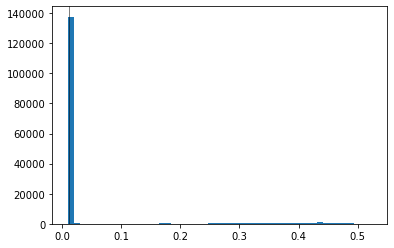

In [44]:
plt.hist(err_ls, 50);
plt.axvline(err_mcmc, color='k', lw=0.5)

In [45]:
Rx_ls = []
Ry_ls = []
# Mp_ls = []

for i in tqdm(ind):
    param = df_mcmc_arr[i][:-2]
    
    
    Kx = -param[0]
    Ky = param[2]

    Jx = -param[-2]
    Jy = param[-1]

    Ry = -(Ky+Jy)
    Rx = -(Kx+Jx)

    Rx_ls.append(Rx)
    Ry_ls.append(Ry)
    
Rx_ls = np.array(Rx_ls)
Ry_ls = np.array(Ry_ls)

  0%|          | 0/137578 [00:00<?, ?it/s]

(0.01, 0.04)

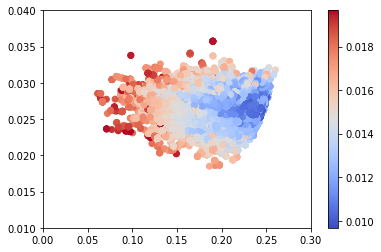

In [60]:
err_subset = err_ls[ind]

plt.scatter(Rx_ls, Ry_ls, c=err_subset, edgecolor=None, cmap='coolwarm', \
            vmin=err_subset.min(), vmax=err_subset.max())
plt.colorbar()
plt.xlim([0, 0.3])
plt.ylim([0.01, 0.04])

In [54]:
Rx_ls.max() - Rx_ls.min()

0.19897766358095212

In [61]:
df_fin

,Spindle,Kfiber,PP distance,Pole,PP-K angle (deg),x_dat,y_dat,xj,yj,L,...,y (mcmc),Rx (mcmc),M0 (mcmc),Ry (mcmc),Kx (mcmc),Ky (mcmc),Jx (mcmc),Jy (mcmc),theta0 (mcmc),RMSE (mcmc)
0,20171215_cell005,0,13.807008,pole_left,28.295192,"[0.0, 0.05889257457563435, 0.1177851491512687,...","[-0.0, 0.028642242347681996, 0.057284484695363...",4.962797,0.38645,6.219349,...,"[0.028722843826586558, 0.05759744781761162, 0....",0.245103,0.076192,0.026009,1.625957,-0.533351,-1.87106,0.507342,0.30512,0.011686
